# Multivariate Gaussian Random Walk

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano

from scipy.linalg import cholesky

%matplotlib inline

In [2]:
RANDOM_SEED = 8927#42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

This notebook shows how to [fit a correlated time series](https://en.wikipedia.org/wiki/Curve_fitting) using multivariate [Gaussian random walks](https://en.wikipedia.org/wiki/Random_walk#Gaussian_random_walk) (GRWs). In particular, we perform a Bayesian [regression](https://en.wikipedia.org/wiki/Regression_analysis) of the time series data against a model dependent on GRWs.

We generate data as the 3-dimensional time series
\begin{equation}
\mathbf y = \alpha_{i[\mathbf t]} +\beta_{i[\mathbf t]} *\frac{\mathbf t}{300} +\xi_{\mathbf t},\quad \mathbf t = [0,1,...,299], \quad\quad\quad(\star)
\end{equation}
where 
- $i\mapsto\alpha_{i}$ and $i\mapsto\beta_{i}$, $i\in\{0,1,2,3,4\}$, are two 3-dimensional Gaussian random walks for two correlation matrices $\Sigma_\alpha$ and $\Sigma_\beta$,
- we define the index 
$$
i[t]= j\quad\text{for}\quad t = 60j,60j+1,...,60j+59, \quad\text{and}\quad j = 0,1,2,3,4,
$$ 
- $*$ means that we multiply the $j$-th column of the $3\times300$ matrix with the $j$-th entry of the vector for each $j=0,1,...,299$, and 
- $\xi_{\mathbf t}$ is a $3\times300$ matrix with iid normal entries $N(0,\sigma^2)$.


So the series $\mathbf y$ changes due to the GRW $\alpha$ in five occasions, namely steps $0,60,120,180,240$. Meanwhile  $\mathbf y$ changes at steps $1,60,120,180,240$ due to the increments of the GRW $\beta$ and  at every step  due to the weighting of  $\beta$ with $\mathbf t/300$. Intuitively, we have a noisy ($\xi$) system that is shocked five times over a period of 300 steps, but the impact of the $\beta$ shocks gradually become more significant at every step. 

Let's generate and plot the data.

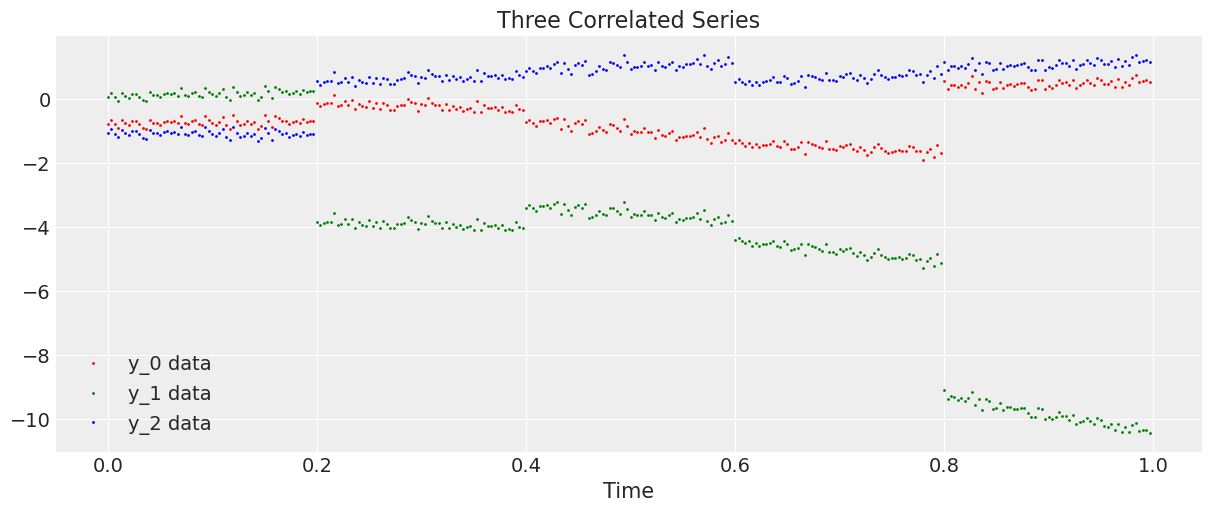

In [3]:
D = 3 # Dimension of random walks
N = 300 # Number of steps
sections = 5 # Number of sections
period = N / sections # Number steps in each section

Σ_α = rng.standard_normal((D, D))
Σ_α = Σ_α.T.dot(Σ_α) # Construct covariance matrix for α
L_α = cholesky(Σ_α, lower=True) # Obtain its Cholesky decomposition

Σ_β = rng.standard_normal((D, D))
Σ_β = Σ_β.T.dot(Σ_β) # Construct covariance matrix for β
L_β = cholesky(Σ_β, lower=True) # Obtain its Cholesky decomposition

# Gaussian random walks:
α = np.cumsum(L_α.dot(rng.standard_normal((D, sections))), axis=1).T
β = np.cumsum(L_β.dot(rng.standard_normal((D, sections))), axis=1).T
t = np.arange(N)[:, None] / N
α = np.repeat(α, period, axis=0)
β = np.repeat(β, period, axis=0)
# Correlated series
σ = 0.1
y = α + β * t + σ * rng.standard_normal((N, 1))

#Plot the correlated series
plt.figure(figsize=(12, 5))
plt.gca().set_prop_cycle("color", ["red", "green", "blue"])
plt.plot(t, y, ".", markersize=2, label=("y_0 data","y_1 data","y_2 data"))
plt.title("Three Correlated Series")
plt.xlabel("Time")
plt.legend()
plt.show();

We introduce a scaling class to rescale our data and the time parameter before the sampling and then rescale the predictions to match the unscaled data.

In [4]:
class Scaler:
    def __init__(self):
        mean_ = None
        std_ = None

    def transform(self, x):
        return (x - self.mean_) / self.std_

    def fit_transform(self, x):
        self.mean_ = x.mean(axis=0)
        self.std_ = x.std(axis=0)
        return self.transform(x)

    def inverse_transform(self, x):
        return x * self.std_ + self.mean_

We now construct the regression model in $(\star)$ imposing priors on the GRWs $\alpha$ and $\beta$, on the standard deviation $\sigma$ and hyperpriors on the Cholesky matrices. We use the [LKJ prior](https://www.sciencedirect.com/science/article/pii/S0047259X09000876) for the Cholesky matrices (see this [link for the documentation](https://docs.pymc.io/api/distributions/multivariate.html#pymc3.distributions.multivariate.LKJCholeskyCov) and also [this PyMC notebook](https://docs.pymc.io/notebooks/LKJ.html) for some usage examples.)

In [5]:
def inference(t, y, sections, n_samples=100):
    N, D = y.shape

    # Standardies y and t
    y_scaler = Scaler()
    t_scaler = Scaler()
    y = y_scaler.fit_transform(y)
    t = t_scaler.fit_transform(t)
    # Create a section index
    t_section = np.repeat(np.arange(sections), N / sections)

    # Create theano equivalent
    t_t = theano.shared(np.repeat(t, D, axis=1))
    y_t = theano.shared(y)
    t_section_t = theano.shared(t_section)
    
    with pm.Model() as model:
        # Hyperpriors on Cholesky matrices
        packed_L_α = pm.LKJCholeskyCov("packed_L_α", n=D, eta=2.0, 
                                       sd_dist=pm.HalfCauchy.dist(2.5))
        L_α = pm.expand_packed_triangular(D, packed_L_α)
        packed_L_β = pm.LKJCholeskyCov("packed_L_β", n=D, eta=2.0, 
                                       sd_dist=pm.HalfCauchy.dist(2.5))
        L_β = pm.expand_packed_triangular(D, packed_L_β)

        # Priors on Gaussian random walks
        α = pm.MvGaussianRandomWalk("α", shape=(sections, D), chol=L_α)
        β = pm.MvGaussianRandomWalk("β", shape=(sections, D), chol=L_β)
        
        # Deterministic construction of the correlated random walk
        α_r = α[t_section_t]
        β_r = β[t_section_t]
        regression = α_r + β_r * t_t
        
        # Prior on noise ξ
        σ = pm.HalfNormal("σ", 1.)
        
        # Likelihood
        likelihood = pm.Normal("y", mu=regression, sigma=σ, observed=y_t)
        
        # MCMC sampling
        trace = pm.sample(n_samples, cores=4, return_inferencedata=True)
        
        # Posterior predictive sampling
        ppc = pm.sample_posterior_predictive(trace=trace)

    return trace, ppc, model, y_scaler, t_scaler, t_section

We sample from our model and we return the trace, the posterior predictive samples, the PyMC model, the scaling functions for space and time and the scaled time index. After sampling, we display the energy plot for a visual check for the model's convergence. Lastly, we plot the distribution of posterior predictive samples against the observed data $\mathbf y$ to get a general idea of the accuracy of the model (note that the values of $\mathbf y$ actually correspond to the scaled version of $\mathbf y$).

In [ ]:
trace, ppc, model, y_scaler, t_scaler, t_section = inference(t, y, sections)
az.plot_energy(trace)
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model));

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α, packed_L_β, packed_L_α]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 189 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.


The graphs above look good. Now we plot the observed 3-dimensional series against the average predicted 3-dimensional series, or in other words, we plot the data against the estimated regression curve from the model $(\star)$.

In [ ]:
# Compute the predicted mean of the multivariate GRWs
α_mean = trace.posterior["α"].mean(axis=(0,1)) 
β_mean = trace.posterior["β"].mean(axis=(0,1)) 

# Compute the predicted mean of the correlated series
y_pred = y_scaler.inverse_transform(α_mean[t_section].values 
                                    + β_mean[t_section].values * t_scaler.transform(t))

# Plot the predicted mean
plt.figure(figsize=(12, 6))
plt.gca().set_prop_cycle("color", ["red", "green", "blue"])
plt.plot(t, y, ".", markersize=2, label=("y_0 data","y_1 data","y_2 data"))
plt.plot(t, y_pred, label=("y_0 pred","y_1 pred","y_2 pred"))
plt.xlabel("Time")
plt.legend()
plt.title("Predicted Mean of Three Correlated Series")
plt.show()

Finally, we plot the data against the posterior predictive samples.

In [ ]:
rescaled_ppc_y = y_scaler.inverse_transform(ppc["y"])
plt.figure(figsize=(12, 6))
plt.gca().set_prop_cycle("color", ["red", "green", "blue"])
plt.plot(t, y, ".", markersize=2,  label=("y_0 data","y_1 data","y_2 data"))
plt.plot(t,rescaled_ppc_y[:,:,0].T, color="red", alpha=.003)
plt.plot(t,rescaled_ppc_y[:,:,1].T, color="green", alpha=.003)
plt.plot(t,rescaled_ppc_y[:,:,2].T, color="blue", alpha=.003)
plt.xlabel("Time")
plt.legend()
plt.title("Posterior Predictive Samples and the Three Correlated Series")
plt.show();

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w -p theano,xarray